# CNN Classification with FashionMNIST dataset

In [50]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, random_split
import matplotlib.pyplot as plt
import random

In [51]:
def show_sample(dataset, idx=0):
    """Procedure that showcases an image and its mask."""
    image, mask = dataset[idx]

    # Convert tensors to numpy
    img_np = image.squeeze().cpu().numpy()
    mask_np = mask.squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img_np, cmap="gray")
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(mask_np, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# --- Parametros y aceleracion ---
gpus = torch.cuda.device_count()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # deja que cudnn elija el kernel mas rapido

per_gpu_batch = 2048  # batch por GPU (ajusta segun VRAM; 4x24GB permite subirlo)
batch_size = per_gpu_batch * max(1, gpus)
num_workers = 8  # hilos para prefetch; sube/baja segun CPU
val_fraction = 0.4

pin_memory = device.type == "cuda"
persistent_workers = num_workers > 0

# --- Download Fashion-MNIST ---
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

def filter_classes(dataset, cls, max_samples=None):
    # Filtra clases y permite recortar el dataset para pruebas rapidas
    idx = [i for i, (_, y) in enumerate(dataset) if y in cls]
    
    if max_samples is not None:
        idx = random.sample(idx, min(max_samples, len(idx)))
    
    return Subset(dataset, idx)

selected_classes = list(range(10))
train_subset = filter_classes(train_dataset, selected_classes)
test_subset  = filter_classes(test_dataset, selected_classes)

# --- Create TRAIN / VAL split ---
val_size = int(len(train_subset) * val_fraction)
train_size = len(train_subset) - val_size

train_split, val_split = random_split(
    train_subset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)   # reproducible split
)

# --- DataLoaders (paralelos y con pin_memory) ---
common_loader_kwargs = dict(
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

train_loader = DataLoader(train_split, shuffle=True, **common_loader_kwargs)
val_loader   = DataLoader(val_split,   shuffle=False, **common_loader_kwargs)
test_loader  = DataLoader(test_subset, shuffle=False, **common_loader_kwargs)

print(f"GPUs disponibles: {gpus}")
print(f"Batch total: {batch_size} (por GPU: {per_gpu_batch})")
print(f"Train split: {len(train_split):,}")
print(f"Validation split: {len(val_split):,}")
print(f"Test split: {len(test_subset)}")


GPUs disponibles: 4
Batch total: 4096 (por GPU: 1024)
Train split: 36,000
Validation split: 24,000
Test split: 10000


Vamos ahora a entender mejor qué son las imágenes y cuáles y como están codificadas las etiquetas:

In [53]:
train_subset[155][0].shape

torch.Size([1, 28, 28])

In [54]:
train_subset[155][1]

5

Sabiendo que las imágenes son de $28x28$ píxeles y que cuentan con `0` si son camisetas o `1` si son pantalones, vamos a mostrar unas cuantas:

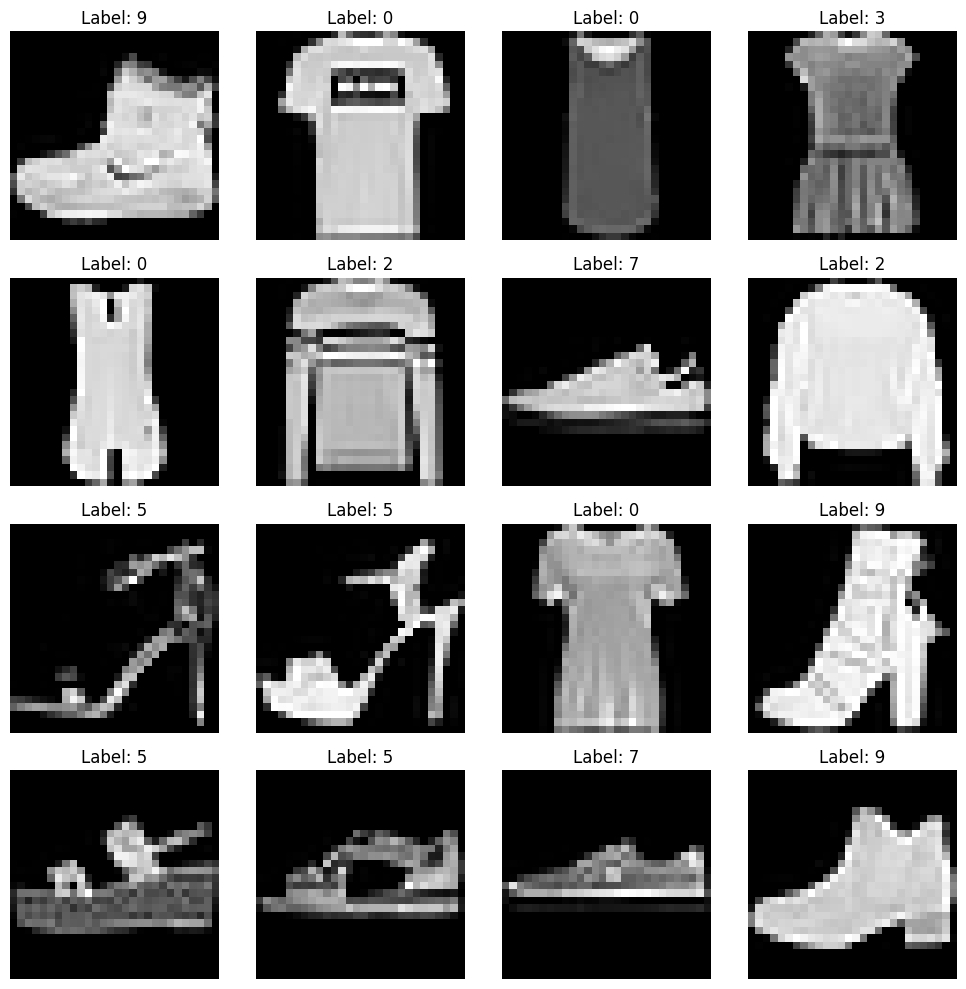

In [55]:
import matplotlib.pyplot as plt

# Number of images to show
num_images = 16
cols = 4
rows = num_images // cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.flatten()

for i in range(num_images):
    img, label = train_subset[i]
    # img is a tensor with shape [1, 28, 28], convert to 2D for imshow
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [56]:
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, drop_prob=0.1):
        super().__init__()
        # Dos convoluciones + BatchNorm + Dropout2d para estabilidad y regularizacion
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(drop_prob),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)


class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_head=0.3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.features = nn.Sequential(
            ConvBlock(32, 64, drop_prob=0.1),
            ConvBlock(64, 128, drop_prob=0.1)
        )
        # GAP reduce parametros y evita sobreajuste al no aplanar todo el mapa
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_head),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        return self.head(x)


In [ ]:
import torch
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

num_epochs = 200  # menos epocas para llegar antes a un buen punto
gpus = torch.cuda.device_count()

model = ImprovedCNN(num_classes=10)
if gpus > 1 and torch.cuda.is_available():
    model = nn.DataParallel(model)  # reparte el batch entre GPUs
model = model.to(device)

# --- Loss y optimizador ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    threshold=1e-3,  # == min_delta
)
scaler = GradScaler(enabled=device.type == "cuda")  # mixed precision

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train")
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(), autocast(enabled=device.type == "cuda"):
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val")
        for x, y in pbar_val:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")


/tmp/ipykernel_118930/1019321874.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=device.type == "cuda")  # mixed precision
Epoch 1/200 - Train:   0%|          | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_118930/1019321874.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=device.type == "cuda"):
Epoch 1/200 - Train: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s, loss=1.43]
/tmp/ipykernel_118930/1019321874.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=device.type == "cuda"):
Epoch 1/200 - Val: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Epoch 1: train_loss=1.7680, val_loss=2.3105, val_acc=0.1027


Epoch 2/200 - Val: 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]


Epoch 2: train_loss=1.2374, val_loss=2.5873, val_acc=0.1339


Epoch 3/200 - Val: 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]


Epoch 3: train_loss=0.9846, val_loss=2.9043, val_acc=0.1584


Epoch 4/200 - Val: 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]


Epoch 4: train_loss=0.8205, val_loss=2.3037, val_acc=0.2597


Epoch 5/200 - Val: 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]


Epoch 5: train_loss=0.7130, val_loss=1.2989, val_acc=0.5330


Epoch 6/200 - Val: 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]


Epoch 6: train_loss=0.6316, val_loss=0.7170, val_acc=0.7545


Epoch 7/200 - Train:  33%|███▎      | 3/9 [00:01<00:02,  2.05it/s, loss=0.583]

/tmp/ipykernel_118930/1724007270.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=device.type == "cuda"):


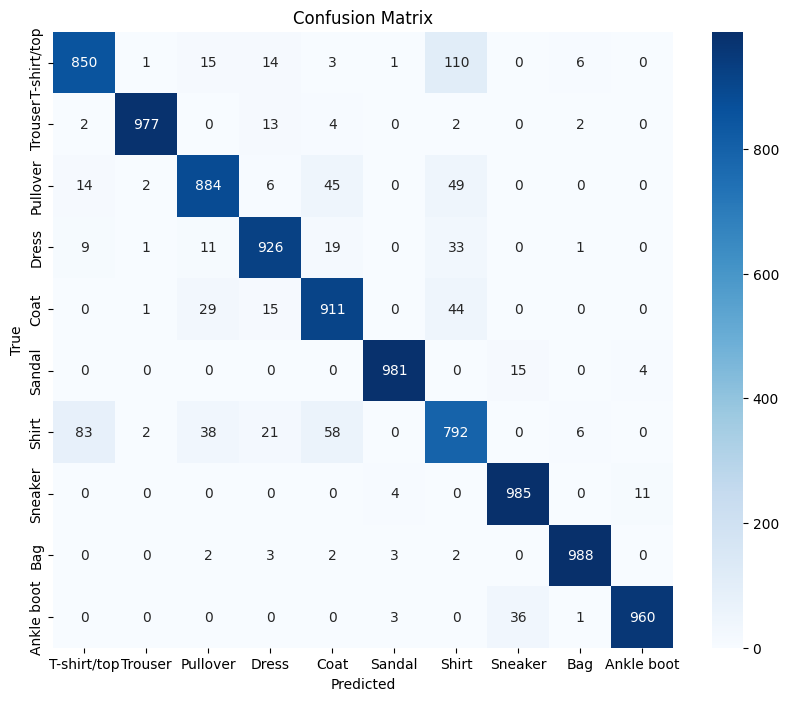

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast

# Map class indices to names (Fashion-MNIST)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad(), autocast(enabled=device.type == "cuda"):
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu()
        
        all_preds.extend(preds.tolist())
        all_labels.extend(y.cpu().tolist())

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# --- Classification Report ---
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.85      0.87      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.90      0.88      0.89      1000
       Dress       0.93      0.93      0.93      1000
        Coat       0.87      0.91      0.89      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.77      0.79      0.78      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

